# Polar plot for one cell, one experiment

## Pick experiment and cell

In [1]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'

In [2]:
exp_id = 501836392
ec_id = 511510650
cell_specimen_id = 517419703
# https://observatory.brain-map.org/visualcoding/search/cell?id=517419703#drifting_grating

In [3]:
import warnings; warnings.simplefilter('ignore')
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
from utils.data_wrappers import *
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

In [4]:
exps = boc.get_ophys_experiments(stimuli=[stim_info.DRIFTING_GRATINGS],
                                experiment_container_ids=[ec_id],
        targeted_structures = ['VISp'],
        imaging_depths = [175],
        cre_lines = ['Cux2-CreERT2'])
exps

[{'id': 501836392,
  'imaging_depth': 175,
  'targeted_structure': 'VISp',
  'cre_line': 'Cux2-CreERT2',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 108,
  'experiment_container_id': 511510650,
  'session_type': 'three_session_A',
  'donor_name': '222425',
  'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222425',
  'fail_eye_tracking': True}]

In [5]:
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

In [6]:
cells[cells['cell_specimen_id'] == cell_specimen_id]

,all_stim,area,cell_specimen_id,donor_full_genotype,dsi_dg,experiment_container_id,failed_experiment_container,g_dsi_dg,g_osi_dg,g_osi_sg,...,specimen_id,tfdi_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
1673,False,VISp,517419703,Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...,0.370128,511510650,False,0.370128,1.0,0.87447,...,495727000,0.44284,0.23219,0.26536,177839004,Cux2-CreERT2,177837320.0,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)


In [7]:
from utils.data_wrappers import *
dg_response_filter = get_dg_response_filter_from_saskia()
dg_response_filter[dg_response_filter['cell_specimen_id'] == cell_specimen_id]

,cell_specimen_id,responsive
30549,517419703,True


Hooray! We found cell **517416426** in experiment container **511510640**, where the experiment is **[dg, VISl, 175, Cux2-CreERT2]**, and the cell is **responsive**

## Polar plot

This cell's plot exactly matches allen's data! https://observatory.brain-map.org/visualcoding/search/cell?id=517419703#drifting_grating.
Great! Our get_avg_normalized_response() is probably right :)

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

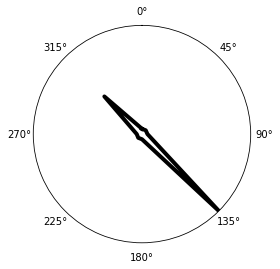

In [8]:
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
 
polardata = get_avg_normalized_response(
        boc=boc,
        session_id=exp_id,
        cell_specimen_id = cell_specimen_id,
        temporal_frequency=2.0)
theta, r = convert_polar_dict_to_arrays(polardata)
fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot(axes, theta, r, color='black', linewidth=4)


# Polar plot for all cells in one experiment

Apply **filtering** for cells in this experiment

In [13]:
exps = boc.get_ophys_experiments(
    experiment_container_ids=[ec_id],
    stimuli=[stim_info.DRIFTING_GRATINGS])
exps = pd.DataFrame.from_dict(exps)
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

dg_response_filter = get_dg_response_filter_from_saskia()
polardata_df = polardata.to_frame()

# in_category_cells = cells[cells.experiment_container_id == ec_id]
# responsive_cells = get_filtered_cells(in_category_cells, dg_response_filter)
# responsive_cells = responsive_cells[responsive_cells['p_dg'] < 0.05]
# # direction selective cells
# dsi_cells_one = responsive_cells[(responsive_cells['dsi_dg'] > 0.9)]
# dsi_cells_two = responsive_cells[(responsive_cells['dsi_dg'] > 0.8)]
# dsi_cells_three = responsive_cells[(responsive_cells['dsi_dg'] > 0.7)]
# dsi_cells_four = responsive_cells[(responsive_cells['dsi_dg'] > 0.6)]
# dsi_cells_five = responsive_cells[(responsive_cells['dsi_dg'] > 0.5)]
# print("direction-selective cells >0.9: %d" % len(dsi_cells_one))
# print("direction-selective cells >0.8: %d" % len(dsi_cells_two))
# print("direction-selective cells >0.7: %d" % len(dsi_cells_three))
# print("direction-selective cells >0.6: %d" % len(dsi_cells_four))
# print("direction-selective cells >0.5: %d" % len(dsi_cells_five))
# responsive_cells = dsi_cells_two

in_category_cells = cells[cells.experiment_container_id == ec_id]
filtered_cells = get_filtered_cells(in_category_cells, dg_response_filter)
new_col = []
for index, row in filtered_cells.iterrows():
    print(index, row)
    polardata_for_this_cell = get_avg_normalized_response(
        boc=boc,
        session_id=exp_id,
        cell_specimen_id = row.cell_specimen_id,
        temporal_frequency=2.0)
    new_dsi_cell = get_new_dsi(polardata_for_this_cell.to_frame())
    new_col.append(new_dsi_cell)
filtered_cells['new_dsi_cell'] = new_col
filtered_cells = filtered_cells[filtered_cells.new_dsi_cell > 0.7]

print ("In this experiment, we have", len(in_category_cells),
       "cells, but after filtering, we have", len(filtered_cells), "cells")


0 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517419064
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.666547
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 0, Length: 61, dtype: object
1 all_stim                                                           False
area                                                                VISp
cell_specime

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

5 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517419245
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.026227
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 5, Length: 61, dtype: object
9 all_stim                                                            True
area                                                                VISp
cell_specime

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

11 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517419288
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.296004
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 11, Length: 61, dtype: object
14 all_stim                                                           False
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

16 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517419310
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.195216
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 16, Length: 61, dtype: object
18 all_stim                                                           False
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

29 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517419533
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                           1.08133
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 29, Length: 61, dtype: object
32 all_stim                                                           False
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

39 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517419723
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.436195
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 39, Length: 61, dtype: object
41 all_stim                                                            True
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

44 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517419753
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.668324
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 44, Length: 61, dtype: object
48 all_stim                                                           False
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

50 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517419785
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.420698
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 50, Length: 61, dtype: object
53 all_stim                                                           False
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

56 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517419807
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.492661
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 56, Length: 61, dtype: object
58 all_stim                                                           False
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

61 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517419832
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.760357
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 61, Length: 61, dtype: object
62 all_stim                                                           False
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

68 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517419874
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                           0.44225
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 68, Length: 61, dtype: object
70 all_stim                                                           False
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

79 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517419985
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.160531
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 79, Length: 61, dtype: object
83 all_stim                                                            True
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

89 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517420057
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.451292
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 89, Length: 61, dtype: object
94 all_stim                                                            True
area                                                                VISp
cell_spec

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

98 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517420102
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.586955
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 98, Length: 61, dtype: object
103 all_stim                                                           False
area                                                                VISp
cell_spe

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

107 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517420153
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                           1.00836
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 107, Length: 61, dtype: object
108 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

113 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517420179
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.556101
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 113, Length: 61, dtype: object
114 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

124 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517420253
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.378423
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 124, Length: 61, dtype: object
125 all_stim                                                            True
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

130 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517420418
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                           1.08461
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 130, Length: 61, dtype: object
132 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

142 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517420694
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.593127
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 142, Length: 61, dtype: object
144 all_stim                                                            True
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

148 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517420741
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                            1.6632
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 148, Length: 61, dtype: object
152 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

159 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517421016
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                         0.0610326
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 159, Length: 61, dtype: object
162 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

165 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517421046
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                           1.90591
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 165, Length: 61, dtype: object
168 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

171 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               517421098
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.935322
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 171, Length: 61, dtype: object
173 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

181 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517421374
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.671993
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 181, Length: 61, dtype: object
187 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

195 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517421666
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.875891
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 195, Length: 61, dtype: object
196 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

198 all_stim                                                            True
area                                                                VISp
cell_specimen_id                                               517421693
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                         0.0395071
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 198, Length: 61, dtype: object
202 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

209 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               586181540
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                               NaN
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 209, Length: 61, dtype: object
213 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

216 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               586182616
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.897754
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 216, Length: 61, dtype: object
223 all_stim                                                            True
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

224 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               586183132
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                          0.255269
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 224, Length: 61, dtype: object
225 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

230 all_stim                                                           False
area                                                                VISp
cell_specimen_id                                               586183202
donor_full_genotype    Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(T...
dsi_dg                                                               NaN
                                             ...                        
tld2_id                                                      1.77837e+08
tld2_name                                                     Camk2a-tTA
tlr1_id                                                        265943423
tlr1_name                                             Ai93(TITL-GCaMP6f)
responsive                                                          True
Name: 230, Length: 61, dtype: object
232 all_stim                                                           False
area                                                                VISp
cell_s

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

In [14]:
thetas = []
rs = []
cell_ids = []
for cell_specimen_id in filtered_cells.cell_specimen_id:
    one_cell_polar_data_dict = get_avg_normalized_response(
        boc=boc,
        session_id=exp_id,
        cell_specimen_id = cell_specimen_id,
        temporal_frequency=2.0)
    if one_cell_polar_data_dict is None:
        continue
    theta, r = convert_polar_dict_to_arrays(one_cell_polar_data_dict)
    thetas.append(theta)
    rs.append(r)
    cell_ids.append(cell_specimen_id)

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/alihamodi/anaconda3/envs/swdb/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5p

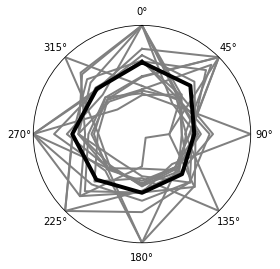

In [15]:
agg_theta, agg_r = get_avg_polar(thetas, rs)
# Or use get_median_polar

fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
polar_plot_population(ax=axes,
                      bold_theta = agg_theta,
                      bold_r = agg_r,
                      grey_thetas = thetas, 
                      grey_rs = rs)

Let's see each cell's polar plot

cell id 517419064
g_dsi_dg 0.323180714314738
dsi_dg 0.666547309721309
p_dg 3.43202755221211e-23
pref_dir_dg 225.0
new_dsi_cell 0.7389698960442612


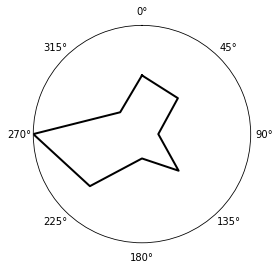

cell id 517419101
g_dsi_dg 0.894810181889737
dsi_dg 1.44419681790238
p_dg 1.06870295993582e-21
pref_dir_dg 45.0
new_dsi_cell 0.8312061843793533


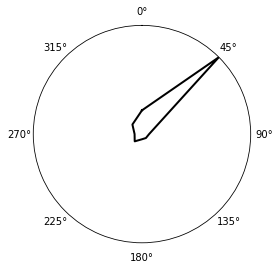

cell id 517419302
g_dsi_dg 0.313968613645282
dsi_dg 1.03324335003793
p_dg 0.00021714823462001
pref_dir_dg 225.0
new_dsi_cell 0.8138400201790341


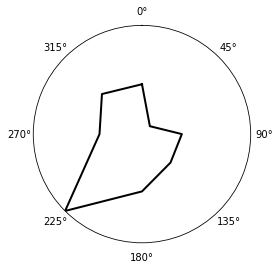

cell id 517419419
g_dsi_dg 0.682317843173677
dsi_dg nan
p_dg 0.617602220065511
pref_dir_dg nan
new_dsi_cell 0.8853869504691069


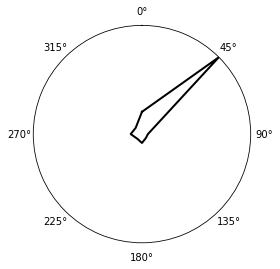

cell id 517419533
g_dsi_dg 0.569288812135067
dsi_dg 1.0813344160444
p_dg 1.57477262575506e-20
pref_dir_dg 0.0
new_dsi_cell 1.0521008464101533


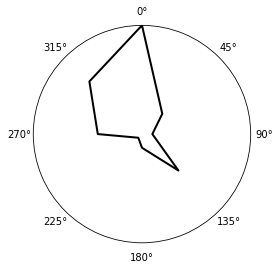

cell id 517419817
g_dsi_dg 0.797295562055789
dsi_dg 1.04114309258443
p_dg 2.95420559028729e-09
pref_dir_dg 0.0
new_dsi_cell 0.8126853122052788


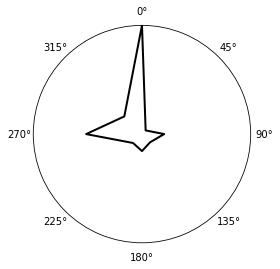

cell id 517420095
g_dsi_dg 0.521825842094179
dsi_dg 1.15859936304583
p_dg 2.14210070921324e-37
pref_dir_dg 135.0
new_dsi_cell 0.8652061160754156


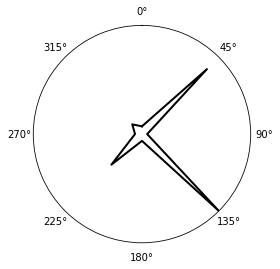

cell id 517420158
g_dsi_dg 0.543926685112805
dsi_dg 0.640976583177879
p_dg 2.27464946630592e-07
pref_dir_dg 0.0
new_dsi_cell 0.7673736904287888


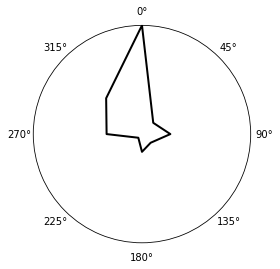

cell id 517420418
g_dsi_dg 0.983418141283648
dsi_dg 1.08460889713801
p_dg 3.40822255519601e-39
pref_dir_dg 315.0
new_dsi_cell 0.7628724106235008


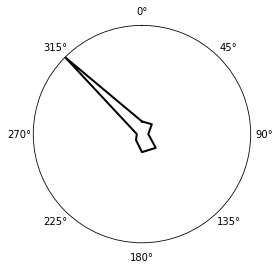

cell id 517420741
g_dsi_dg 0.482328226408032
dsi_dg 1.66320280640752
p_dg 0.0201318098016542
pref_dir_dg 270.0
new_dsi_cell 0.7379653721634287


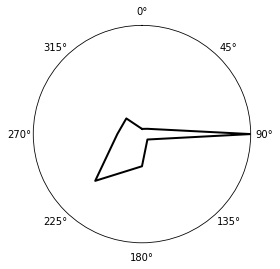

cell id 517420857
g_dsi_dg 1.0
dsi_dg nan
p_dg 0.112634888498636
pref_dir_dg nan
new_dsi_cell 1.4267584396270905


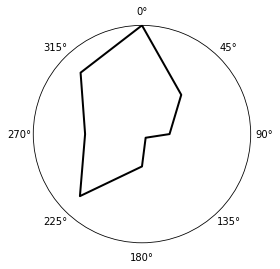

cell id 517421717
g_dsi_dg 0.296236074085501
dsi_dg 0.443556252412256
p_dg 1.53657428717864e-05
pref_dir_dg 225.0
new_dsi_cell 0.8238749376587039


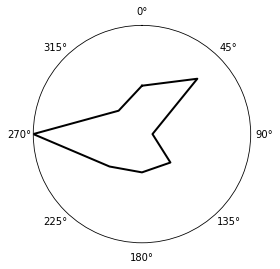

cell id 586180112
g_dsi_dg 0.605580120080405
dsi_dg 1.09196314886361
p_dg 0.0480915327241838
pref_dir_dg 225.0
new_dsi_cell 1.0079086595159745


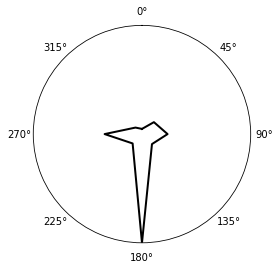

cell id 586181540
g_dsi_dg 0.882952366895696
dsi_dg nan
p_dg 0.00222228444879412
pref_dir_dg 270.0
new_dsi_cell 1.1316951122313421


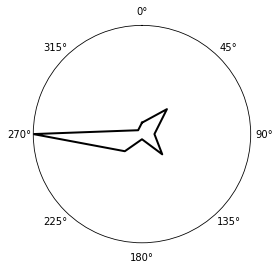

cell id 586183081
g_dsi_dg 0.241764064684105
dsi_dg 0.910470419517597
p_dg 1.81647980345134e-05
pref_dir_dg 225.0
new_dsi_cell 0.7101484069974668


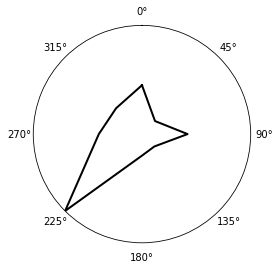

cell id 586183175
g_dsi_dg 0.618550915003317
dsi_dg nan
p_dg 0.329353565905194
pref_dir_dg nan
new_dsi_cell 0.7794000508843429


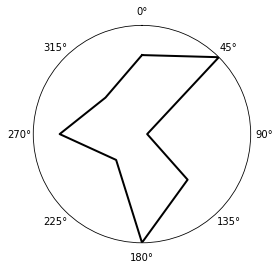

In [16]:
for i in range(len(thetas)):
    cell_id = cell_ids[i]
    print ("cell id", cell_id)
    cell_df = filtered_cells[filtered_cells.cell_specimen_id == cell_id]
    print ("g_dsi_dg", cell_df.g_dsi_dg.values[0])
    print ("dsi_dg", cell_df.dsi_dg.values[0])
    print ("p_dg", cell_df.p_dg.values[0])
    print ("pref_dir_dg", cell_df.pref_dir_dg.values[0])
    print ("new_dsi_cell", cell_df.new_dsi_cell.values[0])
    fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
    polar_plot(axes, thetas[i], rs[i])
    plt.show()